# Poisson-Gamma model

See Mohler et al, *Reducing Bias in Estimates for the Law of Crime Concentration* J.Quantitative Criminology, 2019 https://doi.org/10.1007/s10940-019-09404-1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from itrx import Itr
from scipy.optimize import curve_fit
from scipy.stats import gamma, nbinom, poisson

from spatial import (
    get_force_boundary,
    map_to_spatial_unit,
)
from utils import (
    CATEGORIES,
    Month,
    load_crime_data,
    monthgen,
)

In [3]:
FORCE = "West Yorkshire"
LATEST_DATE = Month(2025, 5)
N_MONTHS = 120
rng = np.random.default_rng(19937)
spatial_unit = "GRID"
spatial_params = {"GRID": {"size": 2600.0}}

force_boundary = get_force_boundary(FORCE)

filter = {"Crime type": CATEGORIES[1]}

raw_crime_data = load_crime_data(FORCE, Itr(monthgen(LATEST_DATE, backwards=True)).take(N_MONTHS), filters=filter)
raw_crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Coniston Avenue,E01007363,Barnsley 004E,Anti-social behaviour,POINT (432210.998 410938.045)
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Wood Royd Hill Lane,E01007426,Barnsley 027D,Anti-social behaviour,POINT (417790.009 405417.966)
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411838.68 447615.131)
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Heather Court,E01010692,Bradford 001D,Anti-social behaviour,POINT (411526.994 447273.002)
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Undercliffe Rise,E01010691,Bradford 002A,Anti-social behaviour,POINT (413203.97 446959.981)
...,...,...,...,...,...,...,...,...
None,2015-06,West Yorkshire Police,West Yorkshire Police,On or near Mill Lane,E01011872,Wakefield 045D,Anti-social behaviour,POINT (444489.02 410629.008)
None,2015-06,West Yorkshire Police,West Yorkshire Police,On or near Mill Street,E01011872,Wakefield 045D,Anti-social behaviour,POINT (444425.029 410683.036)
None,2015-06,West Yorkshire Police,West Yorkshire Police,On or near Green Lane,E01011872,Wakefield 045D,Anti-social behaviour,POINT (444591.98 410823.021)


In [4]:
crime_data, features = map_to_spatial_unit(
    raw_crime_data, force_boundary, spatial_unit, **spatial_params.get(spatial_unit, {})
)
features.area.mean() ** 0.5

np.float64(2600.0)

In [6]:
# ensure we account for crime-free LSOAs in the data
counts = (
    crime_data.groupby(["spatial_unit", "Month"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .sort_index()
)
counts = counts.reindex(features.index, fill_value=0)
# counts.to_csv(f"{spatial_unit}_counts.csv")
counts

Month,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,1,1,0,0,1,0,0,1,0,0,...,0,3,1,1,0,0,0,2,0,0
33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,0,0,2,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
559,9,6,11,11,14,16,8,12,17,14,...,7,3,1,1,3,3,5,3,7,4
560,0,4,4,2,10,10,7,10,3,1,...,2,1,0,1,0,1,0,0,0,0


In [7]:
# this doesnt work well for smaller spatial units
def nbinom_fit_old(sample: pd.Series):
    sample.name = "nbdata"
    # Dispersion parameter from nb model with only interaction term
    nbfit = smf.negativebinomial("nbdata ~ 1", data=sample.to_frame()).fit()
    mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
    alpha = nbfit.params[1]  # Dispersion parameter
    var = mu + alpha * mu**2
    p = mu / var
    n = mu**2 / (var - mu)
    return pd.Series({"n": n, "p": p, "mu": mu})


def poisson_fit(sample: pd.Series) -> float:
    return sample.mean()


def nbinom_fit(sample: pd.Series) -> pd.Series:
    # Histogram of counts (wont contain any zeros)
    values, counts_ = np.unique(sample, return_counts=True)

    # alternative...
    # values = np.bincount(sample)
    # counts_ = range(len(values))
    # Negative binomial PMF for curve_fit
    def nbinom_pdf(x, n, p):
        return nbinom.pmf(x, n, p) * sample.size

    # Initial guesses
    mean = sample.mean()
    var = sample.var()
    p0 = mean / var if var > mean else 0.5
    n0 = mean**2 / (var - mean) if var > mean else 1.0
    popt, _ = curve_fit(nbinom_pdf, values, counts_, p0=[n0, p0], bounds=([1e-6, 1e-6], [np.inf, 1 - 1e-6]))
    n, p = popt
    mu = n * (1 - p) / p
    return pd.Series({"n": n, "p": p, "mu": mu})

In [107]:
# check fitted poisson is just the mean...
# lambda_ = 31.4
# N = 10000
# sim = poisson(lambda_).rvs(N)
# df = pd.DataFrame(data={"sim": np.bincount(sim)})
# df["pdf"] = poisson.pmf(df.index, sim.mean()) * N
# df.plot()

In [8]:
model_params = counts.apply(nbinom_fit).T
# model_params["lambda"] = model_params.index.map(lambda m: poisson_fit(counts[m]))
model_params

,n,p,mu
Month,,,
2015-06,0.276854,0.013323,20.503611
2015-07,0.285688,0.013829,20.373097
2015-08,0.275862,0.012195,22.344355
2015-09,0.339459,0.022273,14.901551
2015-10,0.313054,0.019892,15.424785
...,...,...,...
2025-01,0.265805,0.049057,5.152456
2025-02,0.267891,0.056818,4.446981
2025-03,0.264003,0.030429,8.411996


<Axes: xlabel='Month'>

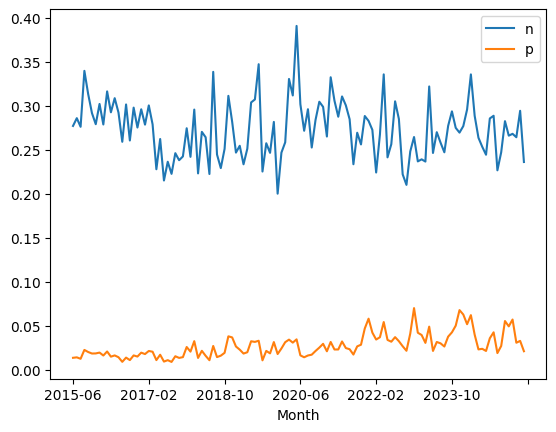

In [109]:
model_params[["n", "p"]].plot()

### Sanity-check the fitted negative binomial distrubution

- observed vs simulated counts
- fitted negative binomial PDF
- compare with fitted Poisson PDF

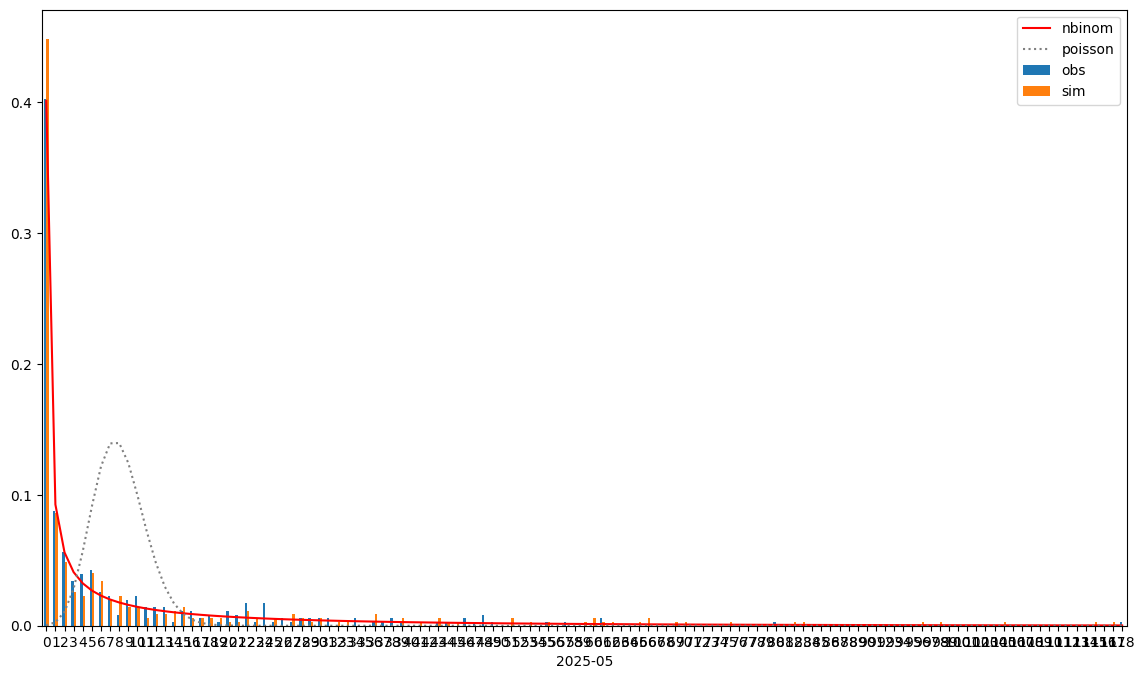

In [9]:
month = str(LATEST_DATE)
n, p, mu = model_params.loc[month]

nb_dist = nbinom(n, p)
nb_sample = nb_dist.rvs(len(features))

df = counts[month].value_counts().rename("obs").reindex(range(counts[month].max() + 1)).to_frame()
# df = df.join(np.unique(nb_sample.)
df = df.join(pd.Series(*np.unique(nb_sample, return_counts=True)[::-1], name="sim"))
df["nbinom"] = nb_dist.pmf(df.index)

# normalise
df.obs = df.obs / df.obs.sum()
df.sim = df.sim / df.sim.sum()

ax = df[["obs", "sim"]].plot.bar(figsize=(14, 8))
df["nbinom"].plot(ax=ax, c="r")

lambda_ = poisson_fit(counts[month])
df["poisson"] = poisson.pmf(df.index, lambda_)
df["poisson"].plot(linestyle=":", c="grey", ax=ax)
ax.legend()
# ax.set_xlim(0, 20)

In [ ]:
errors = pd.Series(index=model_params.index)

for m, n, p, _mu in model_params.itertuples():
    nb_sample = nbinom(n, p).rvs(len(features))
    errors.loc[m] = counts[m].sum() / nb_sample.sum() - 1.0
errors.mean(), np.sqrt((errors**2).mean())
# errors.plot()

(np.float64(0.11947670287302942), np.float64(0.12488956297996753))

obs    2825
sim    2407
dtype: int64

2433.9453988864752

<Axes: >

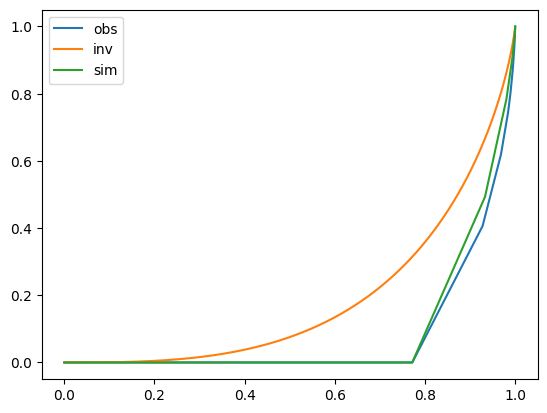

In [94]:
# now sample Poisson lambdas from the gamma dist from one month and compare with actual...
N = len(features)

compare = pd.DataFrame(index=np.linspace(0, 1, N), data={"obs": np.sort(counts[str(LATEST_DATE)])})

# construct the distribution
n, _, mu = model_params.loc[str(LATEST_DATE)]
gamma_dist = gamma(a=n, scale=mu / n)

# compute the inverse cdf
compare["inv"] = gamma_dist.ppf(q=compare.index)

# sample Poisson lambdas
lambdas = gamma_dist.rvs(N)
# now sample each Poisson
compare["sim"] = np.sort(poisson(lambdas).rvs(len(lambdas)))

# show the totals
display(compare[["obs", "sim"]].sum(), mu * N)

compare.obs = compare.obs.cumsum() / compare.obs.sum()
# cant sum due to the inf at x=1 (but the integral of the inverse CDF between 0 and 1 is the mean: mu * N
compare.inv = compare.inv.cumsum() / (mu * N)
compare.sim = compare.sim.cumsum() / compare.sim.sum()

compare.plot()